# Vehicle detection

Here we will play around with various algorithms, color spaces and other techniques for detecting vehicles in images.

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import glob
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC

%matplotlib inline

In [2]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    ax.set_title("".join(axis_labels), fontsize=30)
    
    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:,:,0].ravel(),
        pixels[:,:,1].ravel(),
        pixels[:,:,2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    
    return ax # return Axes3D object for further manipulation

In [3]:
def analyze_image(img):
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64 # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_rgb = img_small_RGB / 255. # scaled to [0, 1], only for plotting

    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 10))

    ax1.imshow(img_RGB)
    ax1.set_title('Original Image', fontsize=30)
    ax3.imshow(img_small_RGB)
    ax3.set_title('Scaled Image RGB', fontsize=30)
    ax4.imshow(img_small_HSV)
    ax4.set_title('Scaled Image HSV', fontsize=30)
    ax5.imshow(img_small_HLS)
    ax5.set_title('Scaled Image HLS', fontsize=30)
    ax6.imshow(img_small_LUV)
    ax6.set_title('Scaled Image LUV', fontsize=30)
    plt.show()

    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.show()
    
    plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
    plt.show()
    
    plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
    plt.show()

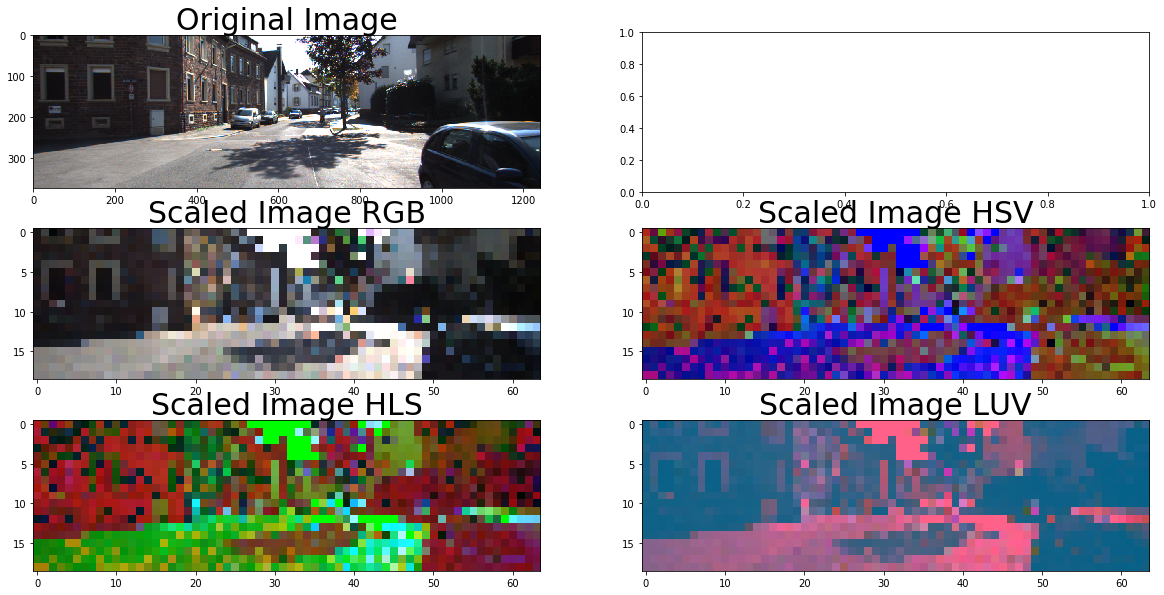

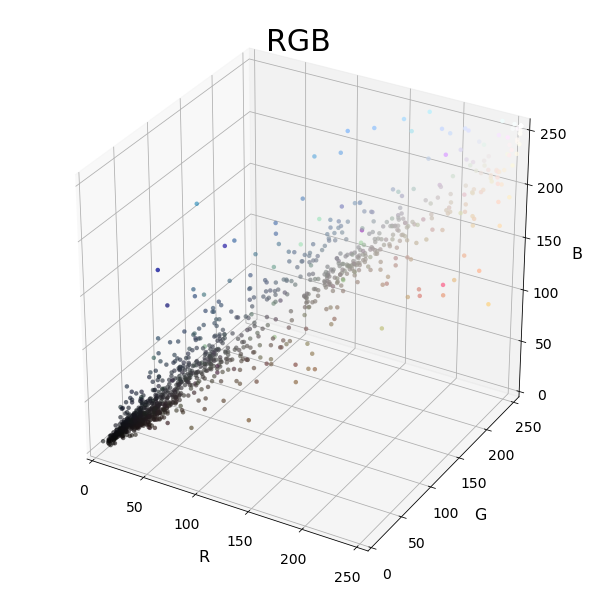

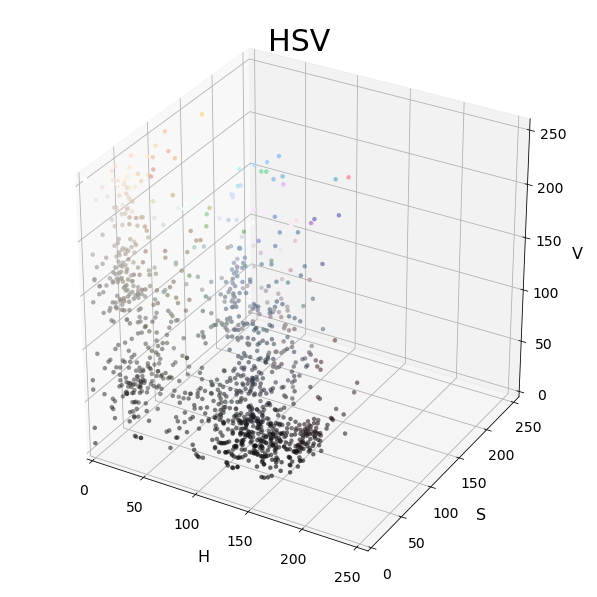

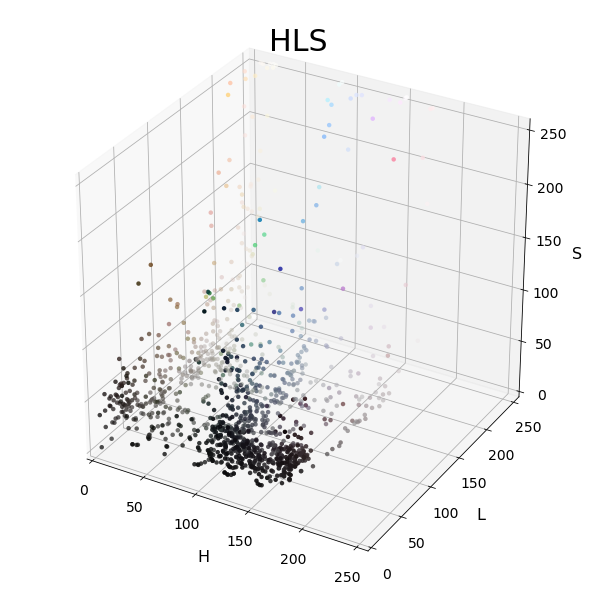

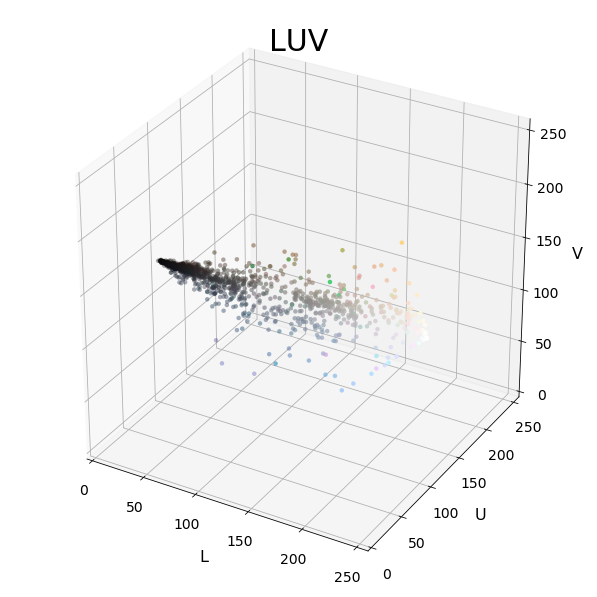

In [4]:
# Read a color image
img = cv2.imread('images/frame3.png')

analyze_image(img)

(32, 32, 3)
(3072,)


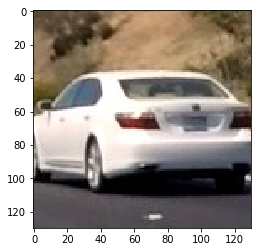

In [5]:
image = mpimg.imread('images/car1.jpg')
small_img = cv2.resize(image, (32, 32))
print(small_img.shape)

feature_vec = small_img.ravel()
print(feature_vec.shape)

plt.imshow(image)
plt.show()

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_sqrt=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, \
            pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), \
            visualise=True,
            feature_vector=feature_vec,
            transform_sqrt=transform_sqrt,
            block_norm='L2-Hys')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, \
            pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), \
            visualise=False,
            feature_vector=feature_vec,
            transform_sqrt=transform_sqrt,
            block_norm='L2-Hys')        
        return features

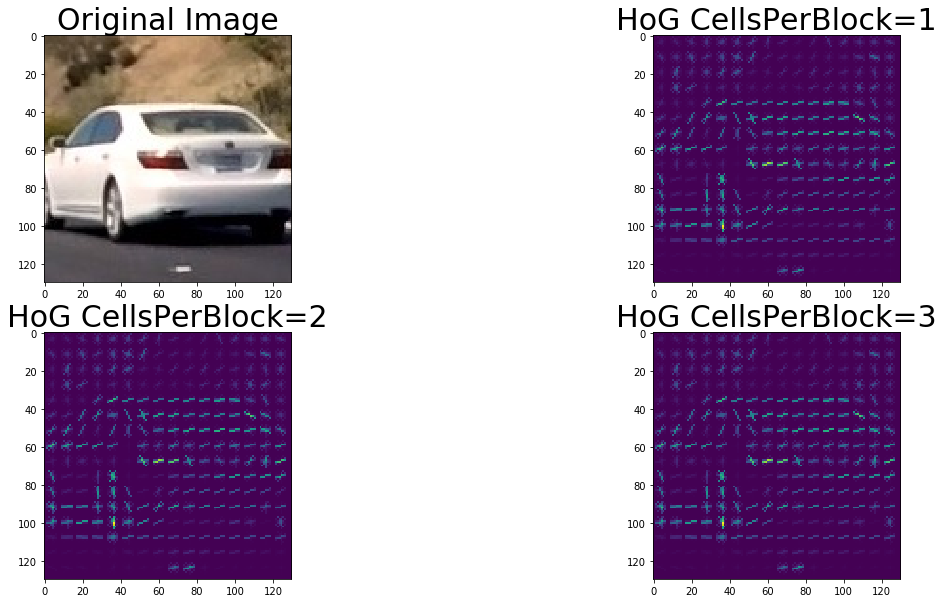

In [7]:
image = mpimg.imread('images/car1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

_, hog_img1 = get_hog_features(gray, 9, 8, 3, vis=True)
_, hog_img2 = get_hog_features(gray, 9, 8, 3, vis=True)
_, hog_img3 = get_hog_features(gray, 9, 8, 3, vis=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hog_img1)
ax2.set_title('HoG CellsPerBlock=1', fontsize=30)
ax3.imshow(hog_img2)
ax3.set_title('HoG CellsPerBlock=2', fontsize=30)
ax4.imshow(hog_img3)
ax4.set_title('HoG CellsPerBlock=3', fontsize=30)

Let's build a small widget to play around with params!

In [8]:
from IPython.html import widgets
from IPython.html.widgets import interact, fixed
from IPython.display import display

D:\Programming\Tools\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
image = mpimg.imread('images/car1.jpg')

def interactive_hog(colorspace, channel, orient, pix_per_cell, cell_per_block, transform_sqrt):
    transformed_img = np.copy(image)
    
    if colorspace == 1: # RGB
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 2: # GRAYSCALE
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2GRAY)
    elif colorspace == 3: # HSV
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2HSV)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 4: # HLS
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2HLS)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 5: # LUV
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2LUV)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 6: # YUV
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2YUV)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 7: # YCrCb
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2YCrCb)
        transformed_img = transformed_img[:,:,channel]
    
    _, hog_img = get_hog_features(transformed_img, orient, pix_per_cell, cell_per_block, \
                                  vis=True, transform_sqrt=transform_sqrt)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    
    ax1.imshow(transformed_img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(hog_img)
    ax2.set_title('Histogram of Gradients', fontsize=30)
    plt.show()

interact(interactive_hog, colorspace=(1, 7), channel=(0, 2), orient=(1, 20), pix_per_cell=(2, 15), cell_per_block=(1, 15), transform_sqrt=False)

<function __main__.interactive_hog>

### Combine and Normalize Features

After extracting binned color features and color histogram features, combine them and normalize. This will help train the classifiers later in the next step.

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

### Classifier Training
Now train a linear classifier on the small data set of cars and not cars

This will me a classifier oriented mostly on color features - i.e. spatial color and color histogram.

In [21]:
def train_color_features():
    # Read in car and non-car images
    images = glob.glob('data-set/*.jpeg')
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)

    # TODO play with these values to see how your classifier
    # performs under different binning scenarios
    spatial = 32
    histbin = 64

    car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
    notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc

In [14]:
train_color_features()

Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 3264
1.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  1.]
0.001 Seconds to predict 10 labels with SVC


Now we are going to create a classifier that will use the Histogram of Gradients as a feature vector.

In [15]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

Now train.

In [22]:
def train_hog_features():
    # Divide up into cars and notcars
    images = glob.glob('data-set/*.jpeg')
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)

    # Reduce the sample size because HOG features are slow to compute
    # The quiz evaluator times out after 13s of CPU time
    sample_size = 500
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

    ### TODO: Tweak these parameters and see how the results change.
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

    t=time.time()
    car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc

In [17]:
train_hog_features()

4.88 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.18 Seconds to train SVC...
Test Accuracy of SVC =  0.96
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
0.0005 Seconds to predict 10 labels with SVC


### Sliding Window

We will use this concept in order to slide a kernel window across our target image and check each of the windows against our car detecting model. If it detects a car, we will draw a box around it, but initially we are only focused in drawing boxes across a sliding window implementation.

In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [19]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int((xspan - xy_window[0]) / nx_pix_per_step) + 1
    ny_windows = np.int((yspan - xy_window[1]) / ny_pix_per_step) + 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ywindow in range(ny_windows):
        for xwindow in range(nx_windows):
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
            # Calculate each window position
            startx = x_start_stop[0] + xwindow * nx_pix_per_step
            endx = startx + xy_window[0]
            starty = y_start_stop[0] + ywindow * ny_pix_per_step
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Let's test the implementation of this sliding window method.

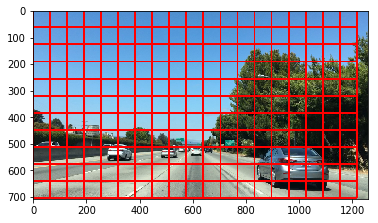

In [20]:
non_window_img = mpimg.imread('images/highway-cars.jpg')

windows = slide_window(non_window_img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(non_window_img, windows, color=(255, 0, 0), thick=5)
plt.imshow(window_img)
plt.show()

**Note**: As we can see from the above image, we will need to use windows of different scales in order to detect cars that are closer or farther away. Having a min and max window size, and going for all sizes in between, will definitely make the algorithm slower. So how can we optimize this?

- we know for sure that we can limit the search in the bottom half of the image, given that this is where cars will most likely be (i.e. ignoring the sky portion of the camera)
- given that the farther away the cars are, the closer to the center of the image they are, and the smaller the window size we need to use - therefore we can also target the sliding window search for cars at specific distances for only a subset of the bottom half of the image.